In [103]:
import cv2
import sys
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import math 
%matplotlib inline

cv2.__version__

'4.0.0'

In [106]:
# Display barcode and QR code location
def get_quater(im):
    height, width = im.shape
    cut_height, cut_width = round(height * 0.5), round(width * 0.5)
    return im[0:cut_height, 0:cut_width], im[0:cut_height, cut_width:width], \
            im[cut_height: height, 0:cut_width], im[cut_height: height, cut_width: width]


def process_image_for_ocr(im):
    # TODO : Implement using opencv
    im_new = remove_noise_and_smooth(im)
    return im_new


def image_smoothening(img, BINARY_THREHOLD = 180):
    ret1, th1 = cv2.threshold(img, BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3


def remove_noise_and_smooth(img):
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 3)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

In [115]:
def process_text_list(text_list, part_length=5):
    i = 0
    ret = []
    length = len(text_list)
    while i < length and len(text_list[i]) < part_length:
        i = i + 1
    ret.append(text_list[i][len(text_list[i])-part_length:])   
    i = i + 1
    while i < length and len(text_list[i]) < part_length:
        i = i + 1
    ret.append(text_list[i][len(text_list[i])-part_length:])
    j = length - 1
    while j > i and len(text_list[j]) < part_length:
        j = j - 1
    ret.append(text_list[j][:part_length])
    return " ".join(ret)

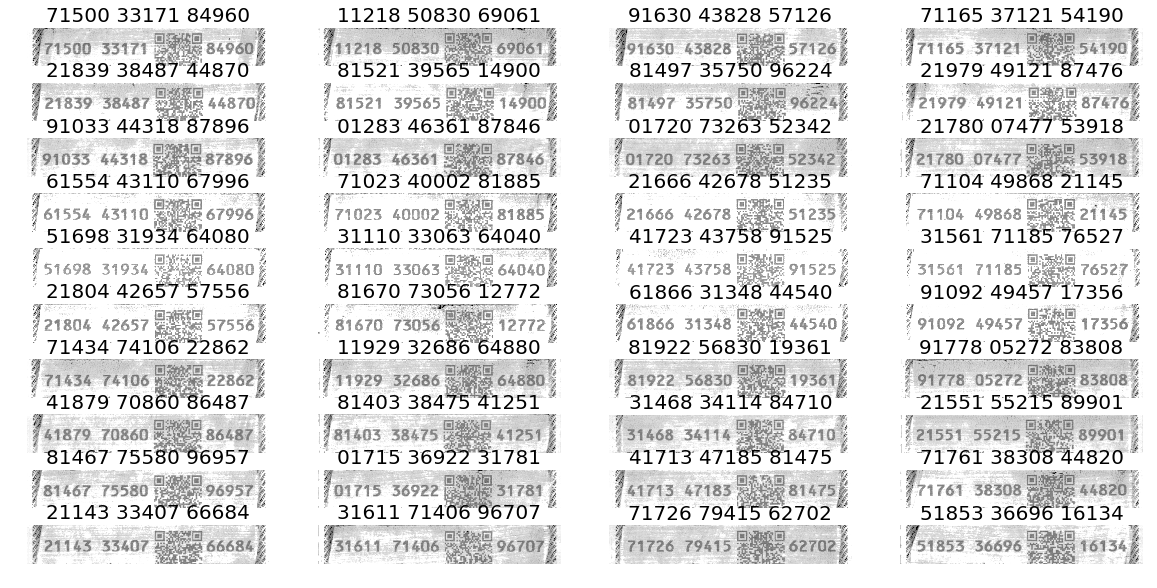

In [126]:
imPaths = [
    "/Users/thanhtu/MyProjects/OCR-SIM/VT20/image0000101A.jpg",
    "/Users/thanhtu/MyProjects/OCR-SIM/VT20/image0000102A.jpg",
    "/Users/thanhtu/MyProjects/OCR-SIM/VT20/image0000103A.jpg",
    "/Users/thanhtu/MyProjects/OCR-SIM/VT20/image0000104A.jpg",
    "/Users/thanhtu/MyProjects/OCR-SIM/VT20/image0000105A.jpg",
    "/Users/thanhtu/MyProjects/OCR-SIM/VT20/image0000106A.jpg",
    "/Users/thanhtu/MyProjects/OCR-SIM/VT20/image0000107A.jpg",
    "/Users/thanhtu/MyProjects/OCR-SIM/VT20/image0000108A.jpg",
    "/Users/thanhtu/MyProjects/OCR-SIM/VT20/image0000109A.jpg",
    "/Users/thanhtu/MyProjects/OCR-SIM/VT20/image0000110A.jpg",
]
# imPath = "images/cmt.jpg"
    
# Uncomment the line below to provide path to tesseract manually
# pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Define config parameters.
# '-l eng'  for using the English language
# '--oem 1' sets the OCR Engine Mode to LSTM only.
#
#  There are four OCR Engine Mode (oem) available
#  0    Legacy engine only.
#  1    Neural nets LSTM engine only.
#  2    Legacy + LSTM engines.
#  3    Default, based on what is available.
#
#  '--psm 3' sets the Page Segmentation Mode (psm) to auto.
#  Other important psm modes will be discussed in a future post.  

config = ('-l digits --oem 1 --psm 8')
im_list = []
# Read image from disk
for _,imPath in enumerate(imPaths):
    whole_im = cv2.imread(imPath, 0)
    im_list.extend(get_quater(whole_im))

columns = 4
rows = math.ceil(len(im_list) / columns)
_, ax_tables = plt.subplots(rows, columns, figsize=[20,10])
    
for index, im in enumerate(im_list):
    height, width = im.shape
    im = im[round(height*0.25):round(height*0.5), 0:width]
#     im = process_image_for_ocr(im)
        # Run tesseract OCR on image
#     print(pytesseract.image_to_data(im, config=config))
    d = pytesseract.image_to_data(im, config=config, output_type=pytesseract.Output.DICT)
#     print(d)
    text_list = []
    n_boxes = len(d['level'])
    for i in range(n_boxes):
#         conf = int(d['conf'][i])
        text = d['text'][i].strip()
        if text == '':
            continue             
        text_list.append(text)
#         (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])                   
#         cv2.rectangle(im, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    row = math.floor(index / columns)
    column = index % columns
    if rows > 1:
        ax = ax_tables[row][column]
    else:
        ax = ax_tables[column]
    ax.axis('off')
    ax.set_title(process_text_list(text_list), fontsize=20)
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
